In [18]:
# Import Packages
using Pkg  # Package to install new packages

# Install packages 
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("Plots")
Pkg.add("Lathe")
Pkg.add("Dates")
Pkg.add("GLM")
Pkg.add("AutoMLPipeline")
#Pkg.add("StatsPlots")
#Pkg.add("MLBase")
#Pkg.add("flux")
#Pkg.add("ANOVA")

# Load the installed packages
using DataFrames
using CSV
using Plots
using Lathe.preprocess: TrainTestSplit
using Dates
using GLM
using AutoMLPipeline

#=
using Statistics
using StatsPlots
using MLBase
using Printf
using Query
using FileIO
=#

# Enable printing of 1000 columns
ENV["COLUMNS"] = 1000

   Resolving package versions...
  No Changes to `C:\Users\arqui\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\arqui\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\arqui\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\arqui\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\arqui\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\arqui\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\arqui\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\arqui\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\arqui\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\arqui\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\arqui\.julia\environments\v1.6\Project.toml`
  No Changes to 

1000

In [19]:
function change_column_dtype(df, colname, newdtype)
    df[!, colname] = convert.(newdtype, df[:, colname])
end

change_column_dtype (generic function with 1 method)

In [20]:
data = DataFrame(CSV.File("../Datasets/sleepdata.csv"))

rename!(data, :"Sleep quality" => "SleepQuality", :"Time in bed" => "Time_in_bed", "Wake up" => "Wake_up", :"Sleep Notes" => "Sleep_Notes", :"Heart rate" => "Heart_rate", :"Activity (steps)" => "Activity_(steps)")

coalesce.(data.Sleep_Notes, "None")

dropmissing!(data);

delete!(data, 1);

In [21]:
const nano = 60000000000 # how many nanoseconds are in a minute

insertcols!(data, :Minutes_in_bed => 1)
for i in range(1, length=nrow(data))
    data.Minutes_in_bed[i] = Dates.value(data.Time_in_bed[i]) / nano
end

In [22]:
data.Start = Date.(data.Start, "yyyy-mm-dd HH:MM:SS");
data.End = Date.(data.End, "yyyy-mm-dd HH:MM:SS");

In [23]:
X = data[:, [5, 6, 7]] |> DataFrame;

Y = data[:, 9] |> Vector;

In [24]:
catf = CatFeatureSelector()
numf = NumFeatureSelector()

stsc = SKPreprocessor("StandardScaler")
ohe = OneHotEncoder()

forest = SKLearner("RandomForestRegressor")
lasso = SKLearner("Lasso")
gradient = SKLearner("GradientBoostingRegressor")

SKLearner("GradientBoostingRegressor_pow", Dict{Symbol, Any}(:output => :class, :name => "GradientBoostingRegressor_pow", :impl_args => Dict{Symbol, Any}(), :learner => "GradientBoostingRegressor"))

In [25]:
#=Categorical Processing
popCat = @pipeline catf
transformCat = fit_transform!(popCat, X, Y)

colNames = names(transformCat)

popOHE = @pipeline (catf |> ohe)
transformOHE = fit_transform(popOHE, X, Y)

names(transformOHE);=#

In [26]:
popRFR = @pipeline ( (numf |> stsc) + (catf |> ohe) ) |> forest;
popLasso = @pipeline ( (numf |> stsc) + (catf |> ohe) ) |> lasso;
popGradient = @pipeline ( (numf |> stsc) + (catf |> ohe) ) |> gradient;

transformRFR = AutoMLPipeline.fit_transform!(popRFR, X, Y);
transformLasso = AutoMLPipeline.fit_transform!(popLasso, X, Y);
transformGradient = AutoMLPipeline.fit_transform!(popGradient, X, Y);

meanRFR, sdRFR = crossvalidate(popRFR, X, Y, "mean_squared_error", 5);
meanLasso, sdLasso = crossvalidate(popLasso, X, Y, "mean_squared_error", 5);
meanGradient, sdGradient = crossvalidate(popGradient, X, Y, "mean_squared_error", 5);

println(meanRFR)
println(meanLasso)
println(meanGradient)

fold: 1, 4179.03673397283
fold: 2, 4254.717333373211
fold: 3, 1752.5851665054247
fold: 4, 2411.2753532945776
fold: 5, 2033.2753099097106
errors: 0
fold: 1, 1077.084942894335
fold: 2, 1931.5306565498086
fold: 3, 3760.3996873863566
fold: 4, 2182.81114545076
fold: 5, 1360.8638570679223
errors: 0
fold: 1, 2330.789337339384
fold: 2, 3966.042516112223
fold: 3, 2088.513053696556
fold: 4, 2911.008964137588
fold: 5, 1888.8025479753892
errors: 0
2926.177979411151
2062.5380578698364
2637.031283852228


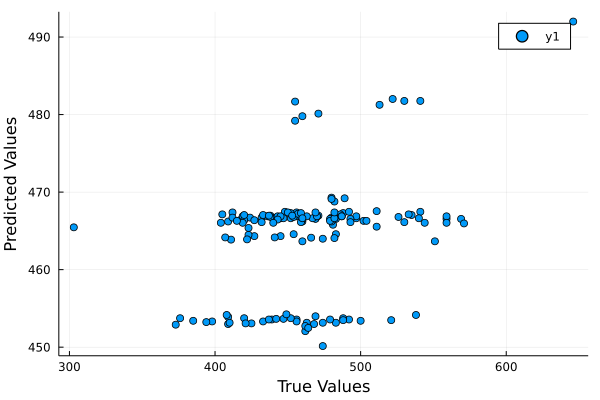

In [27]:
predictions = transformLasso
truevalues = Y

scatter(truevalues, predictions, xlabel = "True Values", ylabel = "Predicted Values")

In [28]:
#=onehotDF = DataFrame(Stressful_day = Bool[], Drank_coffee = Bool[], Drank_tea = Bool[], Worked_out = Bool[], Ate_late = Bool[])

for i in range(1, length = nrow(data))
    currentSleepNote = data.Sleep_Notes[i]
    if occursin(":", data.Sleep_Notes[i])
        sleepList = []

        note1 = split(currentSleepNote, ":")[1]
        note2 = split(currentSleepNote, ":")[2]

        push!(sleepList, note1, note2)

        ohb = onehotbatch(sleepList, ["Stressful day", "Drank coffee", "Drank tea", "Worked out", "Ate late"])

        enc = ohb[:, 1] + ohb[:, 2]
        
        push!(onehotDF, enc)
    else
        sleepList = []

        push!(sleepList, currentSleepNote)

        enc = onehot(currentSleepNote, ["Stressful day", "Drank coffee", "Drank tea", "Worked out", "Ate late"])

        push!(onehotDF, enc)
    end
end

data = hcat(data, onehotDF)=#

In [29]:
#=insertcols!(data, :"Wake_up_ord" => 1)

i = 1
for emoticon in data.Wake_up
    if occursin(":)", emoticon)
        data[i, "Wake_up_ord"] = 2 
        i += 1
    elseif occursin(":|", emoticon)
        data[i, "Wake_up_ord"] = 1
        i += 1
    elseif occursin(":()", emoticon)
        data[i, "Wake_up_ord"] = 0
        i += 1
    end
end=#

In [30]:
#=insertcols!(data, :"Sleep_quality_num" => 1.0)

i = 1
for percentage in data.SleepQuality
    number = percentage[1:end-1]
    #println(parse(Float64, number))
    data[i, "Sleep_quality_num"] = parse(Float64, number)
    i += 1
end

insertcols!(data, :"Sleep_quality_ord" => 1)

i = 1
for num in data.Sleep_quality_num
    #println(num)
    if num >= 0.0 && num < 25.0
        data[i, "Sleep_quality_ord"] = 1
        i += 1
    elseif num >= 25.0 && num < 50.0
        data[i, "Sleep_quality_ord"] = 2
        i += 1
    elseif num >= 50.0 && num < 75.0
        data[i, "Sleep_quality_ord"] = 3
        i += 1
    elseif num >= 75.0
        data[i, "Sleep_quality_ord"] = 4
        i += 1
    end
end
=#